# Project: Investigating the Kaggle Dataset on No-Show Appointments

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In this report I will investigate the  Kaggle Medical Appointment No Shows dataset, which collected information from over 100k medical appointments in Brazil, and focused on whether patients showed up to their appointment or not. There are characteristics about each patient in the rows.<br><br>
The descriptions of each column are as follows (from Kaggle):
>01 - PatientId: Identification of a patient<br>
02 - AppointmentID: Identification of each appointment<br>
03 - Gender: Male or Female<br>
05 - ScheduledDay: The day someone called or registered the appointment, this is before appointment of course.<br>
04 - AppointmentDay: The day of the actual appointment, when they have to visit the doctor.<br>
06 - Age: How old is the patient.<br>
07 - Neighbourhood: Where the appointment takes place.<br>
08 - Scholarship: True or False. In the dataset-set-options document we were given, it states "‘Scholarship’ indicates
whether or not the patient is enrolled in Brasilian welfare program Bolsa Família."<br>
09 - Hipertension: True or False<br>
10 - Diabetes: True or False<br>
11 - Alcoholism: True or False<br>
12 - Handicap: True or False<br>
13 - SMS_received: 1 or more messages sent to the patient, True or False.<br>
14 - No-show: True or False. No = showed, and Yes = did not show.<br>
Although not specified in the Kaggle page or dataset-set-options document, we will consider True = 1 and False = 0.

The dependent variable I will be focusing on in my analysis will be No-show, and for the independent variables I will look at age, neighbourhood, and whether patients received an SMS message or not to see if there are correlations between these factors and whether a patient shows up to their appointment or not.

I will answer the following questions:<br>
1. What proportion of patients did not show up to their appointments?<br>
2. Which neighbourhoods have the most no-shows?
3. Does receiving an SMS message about their appointment, influence whether patients are more likely to show up for their appointments?
4. Do older patients tend to miss their appointments more than younger patients?

In [779]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

First I import the packages I will be using as well as the CSV for my dataset, and I want to quickly look at the first few rows.

In [780]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


<a id='wrangling'></a>
## Data Wrangling

First I want to check to see if there are duplicate rows in the data. There are many rows that will likely be identical in terms of at least some of the columns, so I will not go in and delete all rows that are duplicated in terms of any columns. I will however look at the 1 column that should not have duplicates: AppointmentID, to see if there are any duplicates of this. If so, I would then delete these rows, as they could have been caused by a typing error.

In [781]:
print(df.AppointmentID.duplicated().sum())

0


It looks like there are no duplicates in the AppointmentID column, so I will not delete any rows at this stage.

Next, I want to look at info to see if there are any missing values in the dataset.

In [788]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   age            110527 non-null  int64 
 1   neighbourhood  110527 non-null  object
 2   sms_received   110527 non-null  int64 
 3   no_show        110527 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.4+ MB


Surprisingly, there are no missing values!

When looking at the head above, I see some columns that I do not think I will look at when analyzing my data, such as PatientId, AppointmentID, Gender, ScheduledDay, AppointmentDay, Scholarship, all disease columns, and Handcap. If I were to analyze this data again, I may choose to look at different variables, but I will drop these columns for now. 

First, I will go ahead and drop the columns I mentioned above in order to narrow down my analysis.

In [782]:
df.drop(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap'], axis=1, inplace=True)

I have set the axis as 1 as I wish to delete columns (I will leave this out when deleting any rows, as leaving it out defaults it to rows). I have set this as inplace=True so that the changes will take place within the current table.

In [783]:
df.head() # checking to make sure the columns were deleted

,Age,Neighbourhood,SMS_received,No-show
0,62,JARDIM DA PENHA,0,No
1,56,JARDIM DA PENHA,0,No
2,62,MATA DA PRAIA,0,No
3,8,PONTAL DE CAMBURI,0,No
4,56,JARDIM DA PENHA,0,No


The table is much smaller now, and it is easier to zone in on the variables I would like to explore in my analysis.

My next cleaning step will be to lowercase the column names and also replace the - with a _ in No-show so that I can more easily refer to the columns later and not have to check back to see whether they are capitalized/what format each column has.

In [784]:
df.rename(columns=lambda x: x.lower().replace("-", "_"), inplace=True)

I used the rename function in order to edit the column names.<br>Inside the function, I needed to indicate I wanted to change the names of the columns (columns=)<br>I used a lambda expression as I am performing a simple replacement function and it keeps the code cleaner.<br>x is used as the variable, as we wish to edit all column names, and not just a single column.<br>We then use x.lower() to lowercase all column names, and .replace("-", "_") to replace any - with _.<br>We include inplace=True at the end so that the changes will take place within our current table.

In [785]:
df.head() # checking to make sure all was changed

,age,neighbourhood,sms_received,no_show
0,62,JARDIM DA PENHA,0,No
1,56,JARDIM DA PENHA,0,No
2,62,MATA DA PRAIA,0,No
3,8,PONTAL DE CAMBURI,0,No
4,56,JARDIM DA PENHA,0,No


This looks better! Now I would like to dive deeper into the data.

In [786]:
df.shape # having a quick look at how many rows we have

(110527, 4)

In [787]:
df.describe() # here I can see some summary statistics for the age and sms_received columns.

,age,sms_received
count,110527.000000,110527.000000
mean,37.088874,0.321026
std,23.110205,0.466873
min,-1.000000,0.000000
25%,18.000000,0.000000
50%,37.000000,0.000000
75%,55.000000,1.000000
max,115.000000,1.000000


The range for age is quite interesting to see: 116 years! I imagine that the minimum value of -1 would refer to a baby still in the womb, which is a bit of a strange concept. I will have a look to see if there are more -1 rows in the age column and may decide to delete these.<br><br>Looking at describe for sms_received is not really helpful as we are evaluating these as True or False. I will count these later on to look at a proportion instead.

Now I will have a look at the age column to see how many rows have values <0

In [789]:
df.age.value_counts()

 0      3539
 1      2273
 52     1746
 49     1652
 53     1651
        ... 
 115       5
 100       4
 102       2
 99        1
-1         1
Name: age, Length: 104, dtype: int64

It looks like there are quite a few newborns (age 0), but only the 1 row with a -1 value. It seems to me like this could have potentially been a typing error, so I will go ahead and remove this row.

In [790]:
df.loc[df['age'] == -1]

,age,neighbourhood,sms_received,no_show
99832,-1,ROMÃO,0,No


First I locate the row using .loc and searching for -1 in the age column. Looks like this is in row 99832.<br>Now that I know which row this is in, I can drop this single row.

In [793]:
df.drop(df.index[99831], inplace=True)

I dropped the row using .drop. We need to keep in mind Pandas 0 based numbering, which is why I have dropped 99831 although the row number is actually 99832.<br>As I did not set axis=1 (which refers to columns), the function defaulted to axis=0 (rows).<br>We include inplace=True at the end so that the changes will take place within our current table.

In [794]:
df.describe()

,age,sms_received
count,110525.000000,110525.000000
mean,37.089491,0.321031
std,23.109953,0.466875
min,0.000000,0.000000
25%,18.000000,0.000000
50%,37.000000,0.000000
75%,55.000000,1.000000
max,115.000000,1.000000


Here we can see that the min is now 0 instead of -1 as we dropped that row.

I also want the data types and values in sms_received and no_show to match to make this more clear.<br>First I will change the data type for sms_received from integer to object (string).

In [795]:
df['sms_received'] = df["sms_received"].astype(str)

I used .astype to change the sms_received column to a string (or object as Pandas calls it)

In [796]:
df.info() # quick check to make sure it worked, which it did

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110525 entries, 0 to 110526
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   age            110525 non-null  int64 
 1   neighbourhood  110525 non-null  object
 2   sms_received   110525 non-null  object
 3   no_show        110525 non-null  object
dtypes: int64(1), object(3)
memory usage: 4.2+ MB


I also want to change the values in both sms_received and no_show to Yes/No to make things consistent.<br>Now, if a patient received an sms about their appointment, the row will show Yes, and if they did not receive an SMS, it will show No.

In [797]:
df["sms_received"].replace({"1": "Yes", "0": "No"}, inplace=True)

I used .replace here for each of the columns I wanted to change, and the values in the {} changed from the value before the : to the value after the :<br>Again, I have entered inplace=True here.

In [798]:
print(df) # quickly check this worked

        age      neighbourhood sms_received no_show
0        62    JARDIM DA PENHA           No      No
1        56    JARDIM DA PENHA           No      No
2        62      MATA DA PRAIA           No      No
3         8  PONTAL DE CAMBURI           No      No
4        56    JARDIM DA PENHA           No      No
...     ...                ...          ...     ...
110522   56        MARIA ORTIZ          Yes      No
110523   51        MARIA ORTIZ          Yes      No
110524   21        MARIA ORTIZ          Yes      No
110525   38        MARIA ORTIZ          Yes      No
110526   54        MARIA ORTIZ          Yes      No

[110525 rows x 4 columns]


Now I am happy with the cleanliness of my data, and am ready to move on to the exploration stage.

<a id='eda'></a>
## Exploratory Data Analysis

### Question 1: What proportion of patients did not show up to their appointments?

First I want to look at the counts of no shows versus showed patients.

In [799]:
df.no_show.value_counts()

No     88206
Yes    22319
Name: no_show, dtype: int64

So it looks like there were 22319 no shows versus 88206 showed patients, so about 4x as many showed patients.
Let's quickly look at this difference in a bar graph.

In [800]:
showed_count = df.no_show.value_counts()[0]
no_show_count = df.no_show.value_counts()[1]

First I set the showed_count index as 0 to grab the first value in the no_show value counts (no_show == 'No' means showed), and then the no_show_count index as 1, in order to get the second value. Then I plug these in to look at the difference in a bar graph.

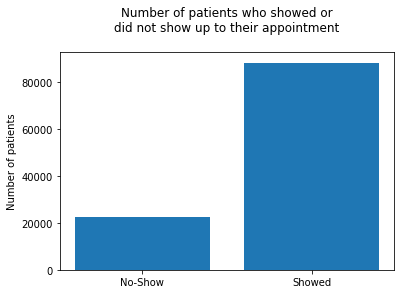

In [801]:
locations = [1, 2]
heights = [no_show_count, showed_count]
labels = ['No-Show', 'Showed']
plt.bar(locations, heights, tick_label=labels)
plt.title("Number of patients who showed or\ndid not show up to their appointment\n")
plt.ylabel("Number of patients");

To more clearly show this difference, let's have a look at the same graph, but with proportions instead of total patients.

In [813]:
total_noshow = df.shape[0] # this refers to the total number of rows in the table
prop_noshow = no_show_count/total_noshow # I then divide no_show_count and showed_count by total_noshow to get proportions.
prop_showed = showed_count/total_noshow
print(prop_noshow, prop_showed)

0.2019362135263515 0.7980637864736485


I then plot this in a bar graph as I did above.

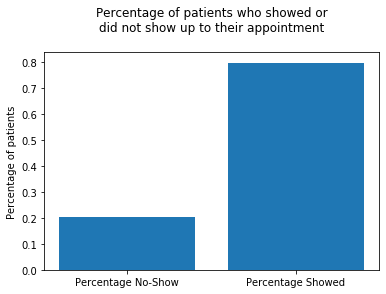

In [804]:
locations = [1, 2]
heights = [prop_noshow, prop_showed]
labels = ['Percentage No-Show', 'Percentage Showed']
plt.bar(locations, heights, tick_label=labels)
plt.title("Percentage of patients who showed or\ndid not show up to their appointment\n")
plt.ylabel("Percentage of patients");

While the percentage of patients who showed is clearly significantly higher than those who did not, 20% is still a significant figure, and would likely be worth investigating for doctors' offices, as no-shows would likely have a negative effect on scheduling, and patients who really need to be seen would likely need to wait longer for an appointment as other appointments would have been taken up by those who did not show.

### Question 2: Which neighbourhoods have the most no-shows?

First, I want to group by neighbourhood, and show the neighborhood with the sum of the no shows (no_show is 'Yes') for each neighbourhood.

In [805]:
noshows_neighbourhoods = df.groupby('neighbourhood')['no_show'].apply(lambda x: (x=='Yes').sum())
print(noshows_neighbourhoods)

neighbourhood
AEROPORTO                1
ANDORINHAS             521
ANTÔNIO HONÓRIO         50
ARIOVALDO FAVALESSA     62
BARRO VERMELHO          91
                      ... 
SÃO JOSÉ               428
SÃO PEDRO              515
TABUAZEIRO             573
UNIVERSITÁRIO           32
VILA RUBIM             141
Name: no_show, Length: 81, dtype: int64


Now I have the number of no shows for each neighborhood.<br><br>Steps:<br>1. I first grouped by the neighborhood, and then set what I want to evaluate the neighborhood by (no shows).<br>2. I used .apply in order to evaluate each value in the no_show column to see the rows with Yes.<br>3. The lambda function simplifies this, and then sums the no shows for each neighborhood.<br><br>This is helpful to look at, but the neighborhoods are sorted alphabetically by neighborhood name, and I am actually interested in looking at the neighborhoods with the highest number of no shows in order to take a look at these on a graph. So I will need to sort descending by total number of no shows instead.<br><br>Reference: https://stackoverflow.com/questions/27488080/python-pandas-filter-rows-after-groupby

In [806]:
top_neighbourhoods = noshows_neighbourhoods.reset_index(name='no_show').sort_values(by=['no_show'], ascending = False).head()
print(top_neighbourhoods)

     neighbourhood  no_show
38  JARDIM CAMBURI     1465
43     MARIA ORTIZ     1219
36         ITARARÉ      923
59     RESISTÊNCIA      906
10          CENTRO      703


Here I took the noshows_neighbourhoods from the above result and added a few more functions in order to get my desired result of the top 5 neighborhoods in terms of no shows.<br><br>1. I used .reset_index in order to change the index to no_show (instead of neighborhood) so I can have access to this column later, and this is the column I want to sort on as well.<br>2. I then used sort_values to sort by the no_show column, and set ascending to False so we get the largest values first (sort descending).<br>3. For this question I am interested only in the first 5 values, which is why I print the head.<br><br>
When I print top_neighbourhoods, I am presented with a row number, neighbourhead name and total no_shows for each of the top 5 neighbourhoods.<br><br>Reference: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html<br><br>Now I want to plot these values in a graph to more clearly show the differences between neighborhoods.

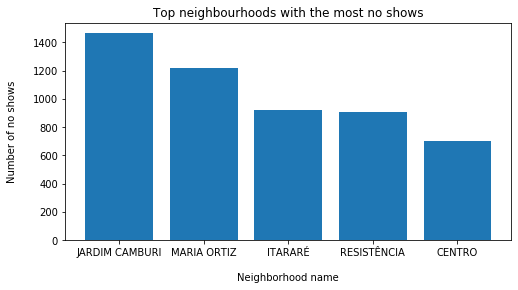

In [807]:
locations = [1,2,3,4,5] # first I set my locations 1-5 (as we will have 5 bars, 1 per neighbourhood)
# I set my heights to the no_show totals shown in the no_show column in top_neighbourhoods.
# I refer to the row number in the index as we will need to match each of these with the appropriate label.
heights = [top_neighbourhoods.no_show[38], top_neighbourhoods.no_show[43], top_neighbourhoods.no_show[36], top_neighbourhoods.no_show[59], top_neighbourhoods.no_show[10]]
# I set the labels as the name of each neighbourhood matched with its no_show value (same column number).
labels = [top_neighbourhoods.neighbourhood[38], top_neighbourhoods.neighbourhood[43], top_neighbourhoods.neighbourhood[36], top_neighbourhoods.neighbourhood[59], top_neighbourhoods.neighbourhood[10]]
plt.figure(figsize=(8, 4)) # I want to make the graph bigger as we will have 5 bars.
plt.bar(locations, heights, tick_label=labels)
plt.title("Top neighbourhoods with the most no shows")
plt.xlabel("\nNeighborhood name")
plt.ylabel("Number of no shows\n");

We can see here that even amongst the neighborhoods with the top 5 highest number of no shows, there is a significant difference between Jardim Camburi and Centro. Up above, when we looked at noshows_neighbourhoods, we could see that the numbers were quite dispersed. This could come down to something simple, like perhaps the top 5 neighborhoods have much higher populations than other neighborhoods with fewer no shows, but could also be caused by many other factors, such as commute time, or whether a patient is reminded of their appointment or not, etc.<br><br>I will look at one of these potential factors in my next question.

### Question 3: Does receiving an SMS message about their appointment, influence whether patients are more likely to show up for their appointments?

Before really diving in to answering this question, let's see how many patients have received an SMS versus those who have not:

In [808]:
df.sms_received.value_counts()

No     75043
Yes    35482
Name: sms_received, dtype: int64

Less than half of the patients received SMS messages about their appointments: it looks like this could potentially be contributing towards no-shows.

Let's look at if there are differences between an SMS being received or not for each group (no shows and showed).

In [809]:
sms_yes = df.loc[df['sms_received'] == 'Yes']
sms_no = df.loc[df['sms_received'] == 'No']

Here we locate the patients (using .loc) who either received or did not receive an SMS, by looking in the sms_received column for Yes or No.

In [810]:
sms_yes_did_not_show = sms_yes.groupby('sms_received')['no_show'].apply(lambda x: (x=='Yes').sum()).reset_index(name='did_not_show')
sms_yes_showed = sms_yes.groupby('sms_received')['no_show'].apply(lambda x: (x=='No').sum()).reset_index(name='showed')

sms_no_did_not_show = sms_no.groupby('sms_received')['no_show'].apply(lambda x: (x=='Yes').sum()).reset_index(name='did_not_show')
sms_no_showed = sms_no.groupby('sms_received')['no_show'].apply(lambda x: (x=='No').sum()).reset_index(name='showed')

Here we create subgroups:<br> 
__sms_yes_did_not_show__ = patients who received an SMS but still did not show to their appointment<br> 
__sms_yes_showed__ = patients who received an SMS and showed<br> 
__sms_no_did_not_show__ = patients who did not receive an SMS and did not show to their appointment<br> 
__sms_no_showed__ = patients who did not receive an SMS but still showed<br><br>
We use similar logic to the above when looking at the neighborhoods with .apply, .sum, and .reset_index, but this time we are not sorting by decreasing or limiting the number of values to be printed, so we can remove .sort_values and .head.<br><br>
Now I want to get ready to plot a graph of this information.

In [811]:
result_sms_yes_did_not_show = sms_yes_did_not_show['did_not_show'][0]
result_sms_yes_showed = sms_yes_showed['showed'][0]
result_sms_no_did_not_show = sms_no_did_not_show['did_not_show'][0]
result_sms_no_showed = sms_no_showed['showed'][0]

I want a single value for each of the above subgroups that I can then plot in a stacked bar graph, which is why I created these new groups. With index of 0, I will only be accessing a single value.<br><br>Using this information I will move forward to plot my graph. I refered to this article for assistance: https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/bar_stacked.html

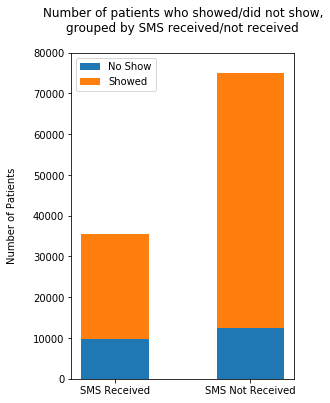

In [812]:
N = 2 # we want 2 bars in total
ind = np.arange(N) # arranges bars in N order.
NoShow = (result_sms_yes_did_not_show, result_sms_no_did_not_show)
Showed = (result_sms_yes_showed, result_sms_no_showed)
# NoShow and Showed = variables to include for the stacked bars 
width = 0.50 # width of bars
plt.figure(figsize=(4, 6)) # size of graph
p1 = plt.bar(ind, NoShow, width) # components of each part of stacked bar
p2 = plt.bar(ind, Showed, width, bottom=NoShow) # bottom: we want NoShow at the bottom of stack

plt.ylabel('Number of Patients\n')
plt.title('Number of patients who showed/did not show,\ngrouped by SMS received/not received\n')
plt.xticks(ind, ('SMS Received', 'SMS Not Received'))
plt.yticks(np.arange(0, 90000, 10000)) # set minimum y-value as 0, maximum as 80000, in increments of 10000
plt.legend((p1, p2), ('No Show', 'Showed'));

plt.show()

In this graph, we can see what we found above: overall, the number of patients not receiving an SMS is substantially higher than those receiving one. But in regards to no shows versus showed, there is a smaller difference between patients having received an SMS or not. It seems then that receiving an SMS or not did not seem to influence the number of no shows very much. It looks like another factor is likely having more of an effect on this, so we will consider another factor in the next question.

### Question 4: Do older patients tend to miss their appointments more than younger patients?

I want to have a look to see if age may be a determining factor in regards to no shows. Do older patients tend to miss their appointments more often than younger patients?

First, I want to look back at describe and value counts to have a look at the ages again.

In [724]:
df.describe()

,age
count,110525.000000
mean,37.089491
std,23.109953
min,0.000000
25%,18.000000
50%,37.000000
75%,55.000000
max,115.000000


We see that the overall mean and median for age for the dataset is about 37 years old, the lower 50% of the patients are between 0-37 years old, and the upper 50% of the patients are at least 37 years old.

In [706]:
noshow = df.no_show == "Yes"
showedup = df.no_show == "No"

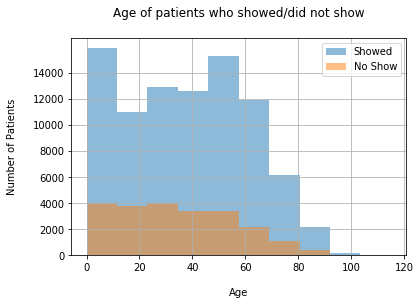

In [743]:
N = 10 # we want 10 bars in total
ind = np.arange(N)
df.age[showedup].hist(alpha=0.5) # here we look at the age of the patients, in terms of whether they show to their appointments
df.age[noshow].hist(alpha=0.5)
plt.ylabel('Number of Patients\n')
plt.title('Age of patients who showed/did not show\n')
plt.xlabel('\nAge')
plt.yticks(np.arange(0, 16000, 2000)) # set minimum y-value as 0, maximum as 16000, in increments of 2000
plt.legend(('Showed', 'No Show'));

This graph is interesting to look at: it looks like the data is right-skewed for both no shows and those who showed, and there are of course significantly more patients who show than not show (which we had identified earlier). I am interested in zooming into the no shows though, so I will create a new graph just of these.

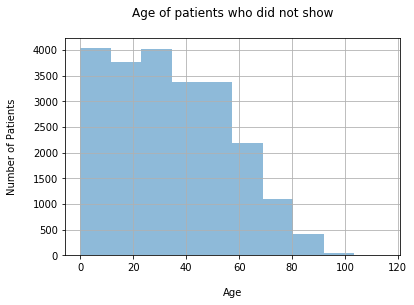

In [749]:
N = 10 # we want 10 bars in total
ind = np.arange(N)
df.age[noshow].hist(alpha=0.5)
plt.ylabel('Number of Patients\n')
plt.title('Age of patients who did not show\n')
plt.xlabel('\nAge')
plt.yticks(np.arange(0, 4500, 500));

We can now much more clearly see which age groups tend to miss their appointments most, and it seems to be the younger patients, those in the lower 50% of ages (<= the median). After around the median, the number of no shows plateaus until around age 58, and then drops pretty consistently for patients older than this.<br><br>To look at this even more closely, let's look at the number of no shows for the top 5 highest in terms of age, using the same formula as above.

In [729]:
top_ages_noshows = df.groupby('age')['no_show'].apply(lambda x: (x=='Yes').sum()).reset_index(name='no_show').sort_values(by=['no_show'], ascending = False).head()
print(ages_noshows)

    age  no_show
0     0      639
1     1      415
17   17      396
19   19      394
30   30      369


Here are the top 5 ages in terms of highest number of no shows (all under age 31).<br><br>Let's also have a quick look at mean/median age for no shows and those who show up.

In [742]:
mean_noshow = df.age[noshow].mean()
mean_show = df.age[showedup].mean()
print('Mean age for no shows: {}'.format(mean_noshow))
print('Mean age for showed: {}'.format(mean_show))

Mean age for no shows: 34.31766656212196
Mean age for showed: 37.790853229939


In [741]:
median_noshow = df.age[noshow].median()
median_show = df.age[showedup].median()
print('Median age for no shows: {}'.format(median_noshow))
print('Median age for showed: {}'.format(median_show))

Median age for no shows: 33.0
Median age for showed: 38.0


We can see here that in general, both the mean and median ages are lower than for those who showed, although they differ only slightly (by about 4-5 years).

<a id='conclusions'></a>
## Conclusions

In this analysis, I investigated the  Kaggle Medical Appointment No Shows dataset, which collected information from over 100k medical appointments in Brazil, and focused on whether patients showed up to their appointment or not, looking at various factors of the patients.<br><br>
First, I wanted to see what percentage of patients did not show to their appointments, and was interested to see that a reasonably high proportion were no shows: about 20%.<br>Knowing this information, I could see why this data was collected, and why someone would be interested in analyzing it: 20% no shows could likely lead to time disruptions/wasted time for both doctors and administrative staff, patients being unable to schedule appointments as appointments may be taken by people that did not end up showing up, and so on.<br><br>
I focused my analysis around 3 independent variables: neighborhood, whether or not an SMS message was sent, and patient age, and explored how these variables may contribute to the number of no shows.<br><br>
In looking at neighborhood, I found that the number of no shows is pretty widely dispersed across neighborhoods, and looked at the top 5 neighborhoods with the most no shows. It would be interesting to perform additional analysis to find reasons for the high number of no shows in these neighborhoods: do they just have higher populations than other neighborhoods with fewer no shows, could they be caused by other factors as well?<br><br>
I next looked into whether the receipt of an SMS message about the appointment would contribute to lower no shows. I first found that less than half of the patients actually received SMS messages about their appointments, and then then plotted the no shows and those who showed against whether or not they received a text message. In regards to no shows versus showed, there is a smaller difference between patients having received an SMS or not, than there is for those who showed. It seems that receiving an SMS or did not have a large influence on the number of no shows.<br><br>
I then had a look at age in terms of no shows: Do older patients tend to miss their appointments more than younger patients? After plotting both no shows and those who showed, as well as looking at the medians and means for both groups, I concluded that generally younger patients (under the age of 31) tend to be no shows over older patients. A large number of no shows are babies (<=1 year old), then teenagers aged 17/19, and then 30 year olds.

### Limitations<br>
In my analysis, I was interested in looking at all 110,525 appointments, and as AppointmentID was not duplicated, I moved forward with other rows that may have had other duplicate values. This could have had an effect on my results, especially when looking at age, as I did not look at distinct patients, and it is possible that each patient could have had multiple appointments, and were therefore counted multiple times.<br><br>I pointed to some areas where I saw correlation in my analysis, but I do not have enough data to and did not conduct statistical tests, and therefore hope that I did not argue causation in my analysis.